In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

#### create simple sequential data

In [2]:
def create_sequence_data(n_sequences=1000, seq_length=10):

    X, y = [], []

    for _ in range(n_sequences):
        # Create a counting sequence starting from random number
        start = np.random.randint(1, 20)
        sequence = list(range(start, start + seq_length))
        target = start + seq_length  # Next number in sequence

        X.append(sequence)
        y.append(target)

    return np.array(X), np.array(y)

In [3]:
def create_long_sequence_data(n_sequences=500, seq_length=50):
    """
    Create LONG sequences to test memory capability
    Pattern: First number + Last number = Target
    This tests if network remembers the beginning!
    """
    X, y = [], []

    for _ in range(n_sequences):
        # Create sequence with pattern at beginning and end
        first_num = np.random.randint(1, 10)
        last_num = np.random.randint(1, 10)

        # Fill middle with random numbers (noise)
        middle = np.random.randint(1, 100, seq_length-2)

        # Create full sequence: [first, ...middle..., last]
        sequence = [first_num] + middle.tolist() + [last_num]
        target = first_num + last_num  # Need to remember BOTH ends!

        X.append(sequence)
        y.append(target)

    return np.array(X), np.array(y)

In [4]:
# Create datasets
print("Creating sequential datasets...")
short_X, short_y = create_sequence_data(1000, 5)
long_X, long_y = create_long_sequence_data(500, 30)

print(f"Short sequences: {short_X.shape}, targets: {short_y.shape}")
print(f"Long sequences: {long_X.shape}, targets: {long_y.shape}")

# Show examples
print("\nShort sequence examples:")
for i in range(3):
    print(f"Sequence: {short_X[i]} → Target: {short_y[i]}")

print("\nLong sequence examples (showing first 5 and last 5 numbers):")
for i in range(2):
    seq = long_X[i]
    print(f"[{seq[0]}, ..., {seq[-1]}] (length={len(seq)}) → Target: {long_y[i]} (sum of first+last)")

Creating sequential datasets...
Short sequences: (1000, 5), targets: (1000,)
Long sequences: (500, 30), targets: (500,)

Short sequence examples:
Sequence: [ 7  8  9 10 11] → Target: 12
Sequence: [15 16 17 18 19] → Target: 20
Sequence: [11 12 13 14 15] → Target: 16

Long sequence examples (showing first 5 and last 5 numbers):
[3, ..., 2] (length=30) → Target: 5 (sum of first+last)
[8, ..., 4] (length=30) → Target: 12 (sum of first+last)


In [5]:
print("\n=== UNDERSTANDING RNN STEP-BY-STEP ===")

class SimpleRNN:
    """
    A very simple RNN implementation to show the concept
    This is educational - not for real use!
    """
    def __init__(self, input_size=1, hidden_size=10, output_size=1):
        self.hidden_size = hidden_size

        # Initialize weights (normally these would be learned)
        self.W_ih = np.random.randn(hidden_size, input_size) * 0.1  # Input to hidden
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.1  # Hidden to hidden (RECURRENT)
        self.W_ho = np.random.randn(output_size, hidden_size) * 0.1  # Hidden to output

        # Biases
        self.b_h = np.zeros((hidden_size, 1))
        self.b_o = np.zeros((output_size, 1))

    def forward_step(self, input_val, prev_hidden):
        """
        One step of RNN processing
        This is the CORE of how RNNs work!
        """
        # Convert input to column vector
        input_val = np.array([[input_val]])

        # RNN Formula: h_t = tanh(W_ih * x_t + W_hh * h_{t-1} + b_h)
        # This is where the RECURRENT magic happens!
        new_hidden = np.tanh(
            np.dot(self.W_ih, input_val) +      # Current input contribution
            np.dot(self.W_hh, prev_hidden) +    # Previous memory contribution (RECURRENT!)
            self.b_h                            # Bias
        )

        # Output: o_t = W_ho * h_t + b_o
        output = np.dot(self.W_ho, new_hidden) + self.b_o

        return output, new_hidden

    def process_sequence(self, sequence):
        """
        Process entire sequence step by step
        Watch how memory accumulates!
        """
        # Initialize hidden state (empty memory)
        hidden = np.zeros((self.hidden_size, 1))

        print(f"Processing sequence: {sequence}")
        print("Step | Input | Hidden State (first 3 values) | Output")
        print("-" * 60)

        # Process each element in sequence
        for step, input_val in enumerate(sequence):
            output, hidden = self.forward_step(input_val, hidden)

            # Show what's happening inside
            hidden_preview = hidden[:3, 0]  # First 3 hidden values
            print(f"{step:4d} | {input_val:5.1f} | {hidden_preview} | {output[0,0]:6.2f}")

        return output[0, 0]  # Return final output

# Demonstrate RNN step-by-step processing
print("Demonstrating how RNN processes sequences step-by-step:")
simple_rnn = SimpleRNN(input_size=1, hidden_size=5, output_size=1)

# Process a simple sequence
test_sequence = [1, 2, 3, 4, 5]
result = simple_rnn.process_sequence(test_sequence)
print(f"Final output: {result:.2f}")


=== UNDERSTANDING RNN STEP-BY-STEP ===
Demonstrating how RNN processes sequences step-by-step:
Processing sequence: [1, 2, 3, 4, 5]
Step | Input | Hidden State (first 3 values) | Output
------------------------------------------------------------
   0 |   1.0 | [ 0.2454308  -0.04513343  0.18727812] |  -0.03
   1 |   2.0 | [ 0.43548453 -0.08360798  0.37935424] |  -0.05
   2 |   3.0 | [ 0.5937639  -0.12039729  0.54125329] |  -0.07
   3 |   4.0 | [ 0.71868253 -0.1581481   0.66942552] |  -0.08
   4 |   5.0 | [ 0.81140841 -0.19699776  0.76590097] |  -0.10
Final output: -0.10


#### Memory: LSTMs and GRUs

In [6]:
print("=== BUILDING REAL RNN MODELS ===")

def create_simple_rnn(sequence_length, hidden_units=20):
    """Simple RNN model"""
    model = keras.Sequential([
        layers.SimpleRNN(hidden_units, input_shape=(sequence_length, 1),
                        return_sequences=False),  # Only return final output
        layers.Dense(1)
    ], name='Simple_RNN')

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_lstm_model(sequence_length, hidden_units=20):
    """LSTM model with gating mechanisms - forget gate"""
    model = keras.Sequential([
        layers.LSTM(hidden_units, input_shape=(sequence_length, 1),
                   return_sequences=False),
        layers.Dense(1)
    ], name='LSTM')

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_gru_model(sequence_length, hidden_units=20):
    """GRU model - reset/update gate"""
    model = keras.Sequential([
        layers.GRU(hidden_units, input_shape=(sequence_length, 1),
                  return_sequences=False),
        layers.Dense(1)
    ], name='GRU')

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare data for training (reshape for RNN input)
def prepare_data(X, y):
    """Reshape data for RNN: (samples, timesteps, features)"""
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    return X_reshaped, y

short_X_rnn, short_y_rnn = prepare_data(short_X, short_y)
long_X_rnn, long_y_rnn = prepare_data(long_X, long_y)

print(f"RNN input shape: {short_X_rnn.shape}")
print("Format: (batch_size, sequence_length, features)")


=== BUILDING REAL RNN MODELS ===
RNN input shape: (1000, 5, 1)
Format: (batch_size, sequence_length, features)


In [7]:
print("\n=== TESTING ON SHORT SEQUENCES (Easy Task) ===")

# Create models
rnn_short = create_simple_rnn(short_X.shape[1])
lstm_short = create_lstm_model(short_X.shape[1])
gru_short = create_gru_model(short_X.shape[1])

print("Model architectures:")
print("\n1. Simple RNN:")
rnn_short.summary()

print("\n2. LSTM (with gates):")
lstm_short.summary()

print("\n3. GRU (simplified gates):")
gru_short.summary()

# Train all models on short sequences
print("Training models on short sequences...")

models = {
    'RNN': rnn_short,
    'LSTM': lstm_short,
    'GRU': gru_short
}

short_histories = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    history = model.fit(short_X_rnn, short_y_rnn,
                       epochs=20, batch_size=32,
                       validation_split=0.2, verbose=0)
    short_histories[name] = history

    # Test performance
    loss, mae = model.evaluate(short_X_rnn, short_y_rnn, verbose=0)
    print(f"{name} - Loss: {loss:.3f}, MAE: {mae:.3f}")


=== TESTING ON SHORT SEQUENCES (Easy Task) ===
Model architectures:

1. Simple RNN:


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)


2. LSTM (with gates):


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)


3. GRU (simplified gates):


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20)             │         1,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,401 (5.47 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

Training models on short sequences...

Training RNN...
RNN - Loss: 42.369, MAE: 4.686

Training LSTM...
LSTM - Loss: 24.900, MAE: 3.322

Training GRU...
GRU - Loss: 25.717, MAE: 3.367


In [8]:
print("\n=== TESTING ON LONG SEQUENCES (Hard Task - Memory Challenge) ===")
print("Task: Remember first number + last number from 30-step sequence")
print("This tests long-term memory capability!")

# Create models for long sequences
rnn_long = create_simple_rnn(long_X.shape[1])
lstm_long = create_lstm_model(long_X.shape[1])
gru_long = create_gru_model(long_X.shape[1])

models_long = {
    'RNN': rnn_long,
    'LSTM': lstm_long,
    'GRU': gru_long
}

long_histories = {}
print("\nTraining on long sequences (this will show the difference!)...")

for name, model in models_long.items():
    print(f"\nTraining {name} on long sequences...")
    history = model.fit(long_X_rnn, long_y_rnn,
                       epochs=30, batch_size=16,
                       validation_split=0.2, verbose=0)
    long_histories[name] = history

    # Test performance
    loss, mae = model.evaluate(long_X_rnn, long_y_rnn, verbose=0)
    print(f"{name} - Loss: {loss:.3f}, MAE: {mae:.3f}")

    # Test on specific examples
    predictions = model.predict(long_X_rnn[:5], verbose=0)
    print(f"Sample predictions vs targets:")
    for i in range(3):
        pred = predictions[i][0]
        target = long_y_rnn[i]
        error = abs(pred - target)
        seq = long_X_rnn[i].flatten()
        print(f"  [{seq[0]:.0f}+{seq[-1]:.0f}={target}] Predicted: {pred:.1f}, Error: {error:.1f}")



=== TESTING ON LONG SEQUENCES (Hard Task - Memory Challenge) ===
Task: Remember first number + last number from 30-step sequence
This tests long-term memory capability!

Training on long sequences (this will show the difference!)...

Training RNN on long sequences...
RNN - Loss: 8.134, MAE: 2.384
Sample predictions vs targets:
  [3+2=5] Predicted: 7.0, Error: 2.0
  [8+4=12] Predicted: 9.6, Error: 2.4
  [7+7=14] Predicted: 11.2, Error: 2.8

Training LSTM on long sequences...
LSTM - Loss: 9.069, MAE: 2.453
Sample predictions vs targets:
  [3+2=5] Predicted: 8.3, Error: 3.3
  [8+4=12] Predicted: 9.0, Error: 3.0
  [7+7=14] Predicted: 10.8, Error: 3.2

Training GRU on long sequences...
GRU - Loss: 8.844, MAE: 2.459
Sample predictions vs targets:
  [3+2=5] Predicted: 7.3, Error: 2.3
  [8+4=12] Predicted: 9.5, Error: 2.5
  [7+7=14] Predicted: 10.7, Error: 3.3


#### Visualizinf gating mechanism

In [9]:
print("\n=== UNDERSTANDING LSTM GATES (Conceptual) ===")

def demonstrate_lstm_gates():

    # Simulate simple gate decisions
    print("Simulated gate decisions for sentence: 'John likes apples. Mary likes oranges.'")
    words = ['John', 'likes', 'apples', '.', 'Mary', 'likes', 'oranges', '.']

    print("\nWord     | Forget | Input | Output | Memory State")
    print("-" * 55)

    memory_content = ""
    for i, word in enumerate(words):
        if word == 'John':
            forget, input_gate, output = 0.1, 0.9, 0.7
            memory_content = "John"
        elif word == 'likes':
            forget, input_gate, output = 0.2, 0.8, 0.8
            memory_content += " likes"
        elif word == 'apples':
            forget, input_gate, output = 0.1, 0.9, 0.9
            memory_content += " apples"
        elif word == '.' and 'John' in memory_content:
            forget, input_gate, output = 0.8, 0.1, 0.5  # End of sentence, start forgetting
            memory_content = ""
        elif word == 'Mary':
            forget, input_gate, output = 0.9, 0.9, 0.7  # Forget John, remember Mary
            memory_content = "Mary"
        elif word == 'likes' and 'Mary' in memory_content:
            forget, input_gate, output = 0.2, 0.8, 0.8
            memory_content += " likes"
        elif word == 'oranges':
            forget, input_gate, output = 0.1, 0.9, 0.9
            memory_content += " oranges"
        else:
            forget, input_gate, output = 0.5, 0.5, 0.5

        print(f"{word:8s} | {forget:6.1f} | {input_gate:5.1f} | {output:6.1f} | {memory_content}")

demonstrate_lstm_gates()

print("\n=== UNDERSTANDING GRU GATES (Simpler) ===")


=== UNDERSTANDING LSTM GATES (Conceptual) ===
Simulated gate decisions for sentence: 'John likes apples. Mary likes oranges.'

Word     | Forget | Input | Output | Memory State
-------------------------------------------------------
John     |    0.1 |   0.9 |    0.7 | John
likes    |    0.2 |   0.8 |    0.8 | John likes
apples   |    0.1 |   0.9 |    0.9 | John likes apples
.        |    0.8 |   0.1 |    0.5 | 
Mary     |    0.9 |   0.9 |    0.7 | Mary
likes    |    0.2 |   0.8 |    0.8 | Mary likes
oranges  |    0.1 |   0.9 |    0.9 | Mary likes oranges
.        |    0.5 |   0.5 |    0.5 | Mary likes oranges

=== UNDERSTANDING GRU GATES (Simpler) ===



Visualization saved as 'rnn_lstm_gru_comparison.png'


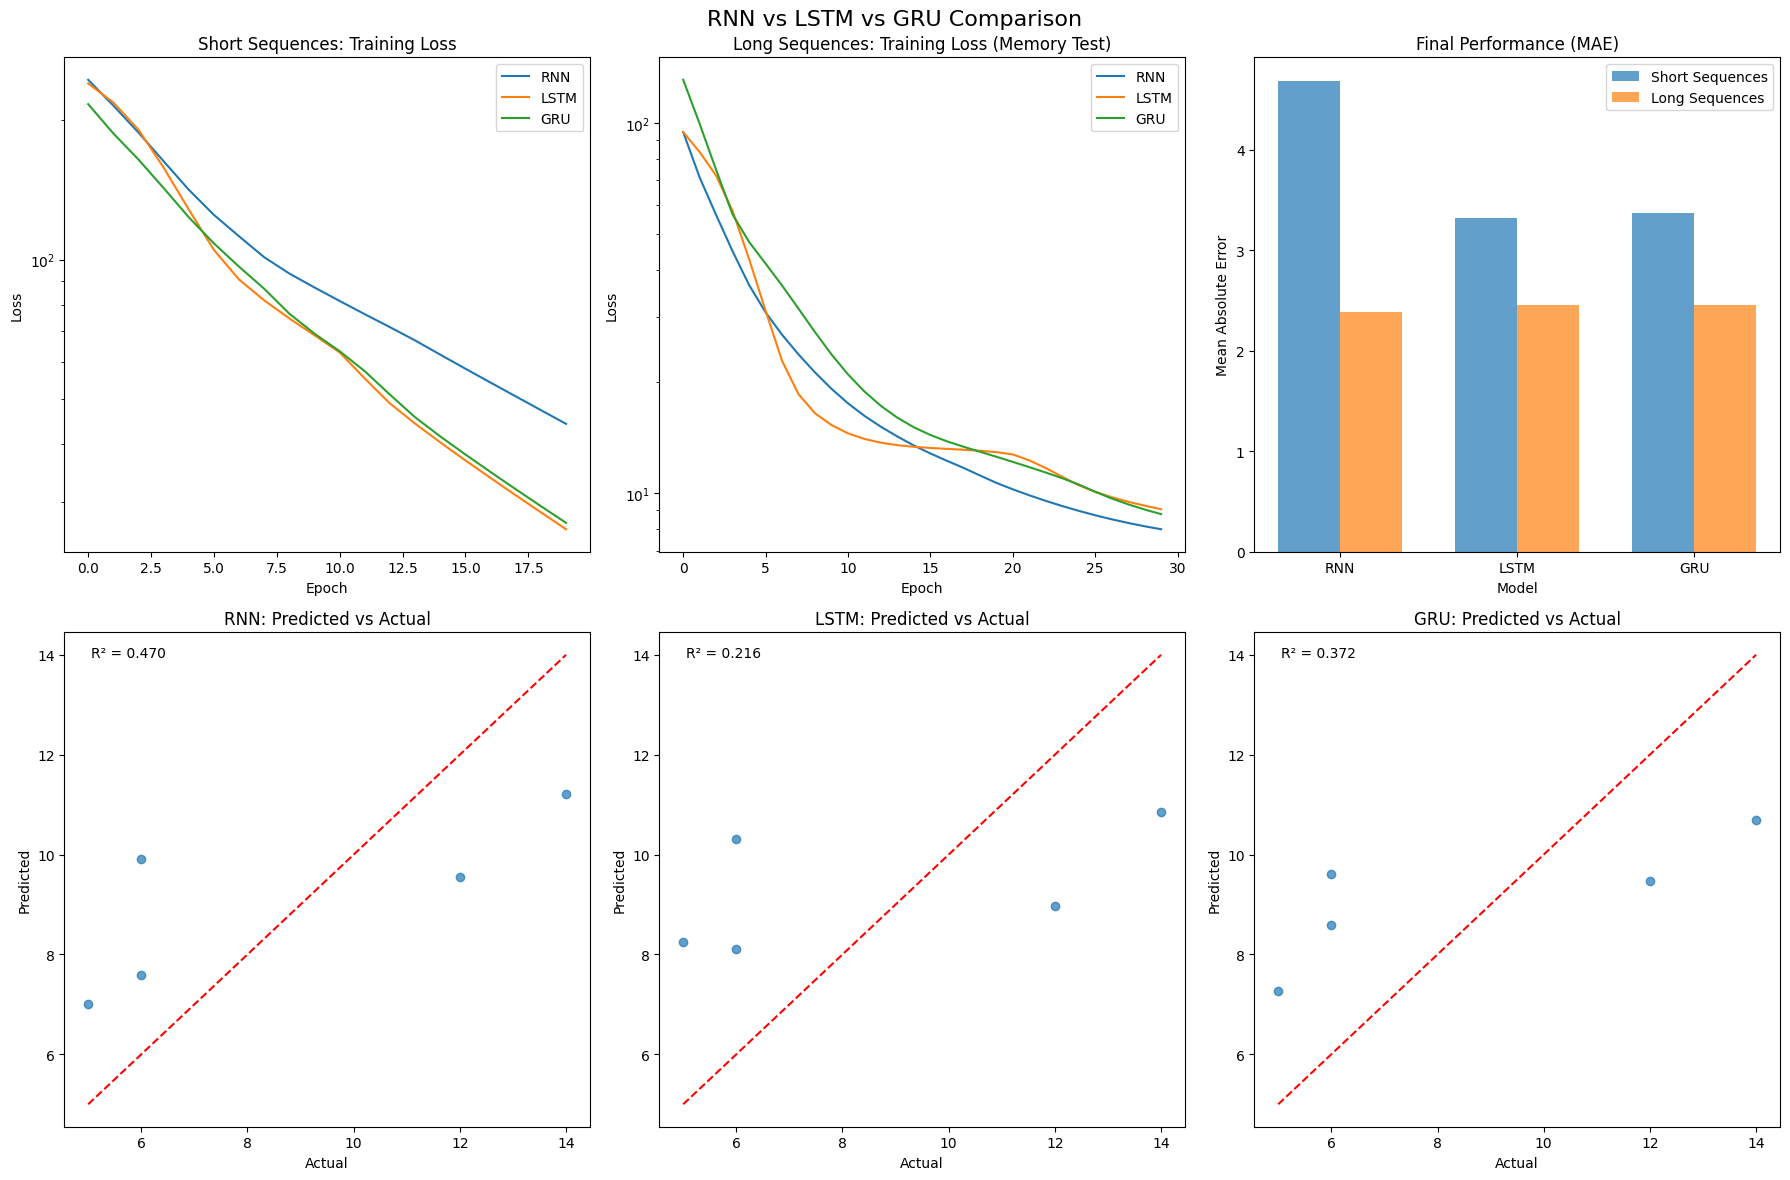

In [10]:
# ====================================================================
# PART 7: VISUALIZATION OF RESULTS
# ====================================================================

def create_comparison_plots():
    """Create comprehensive comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('RNN vs LSTM vs GRU Comparison', fontsize=16)

    # Plot 1: Short sequence training loss
    axes[0,0].set_title('Short Sequences: Training Loss')
    for name, history in short_histories.items():
        axes[0,0].plot(history.history['loss'], label=f'{name}')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].set_yscale('log')

    # Plot 2: Long sequence training loss
    axes[0,1].set_title('Long Sequences: Training Loss (Memory Test)')
    for name, history in long_histories.items():
        axes[0,1].plot(history.history['loss'], label=f'{name}')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].set_yscale('log')

    # Plot 3: Final performance comparison
    short_performance = {}
    long_performance = {}

    for name, model in models.items():
        _, mae = model.evaluate(short_X_rnn, short_y_rnn, verbose=0)
        short_performance[name] = mae

    for name, model in models_long.items():
        _, mae = model.evaluate(long_X_rnn, long_y_rnn, verbose=0)
        long_performance[name] = mae

    names = list(short_performance.keys())
    short_scores = list(short_performance.values())
    long_scores = list(long_performance.values())

    x = np.arange(len(names))
    width = 0.35

    axes[0,2].bar(x - width/2, short_scores, width, label='Short Sequences', alpha=0.7)
    axes[0,2].bar(x + width/2, long_scores, width, label='Long Sequences', alpha=0.7)
    axes[0,2].set_title('Final Performance (MAE)')
    axes[0,2].set_xlabel('Model')
    axes[0,2].set_ylabel('Mean Absolute Error')
    axes[0,2].set_xticks(x)
    axes[0,2].set_xticklabels(names)
    axes[0,2].legend()

    # Plot 4: Sample predictions visualization
    test_indices = [0, 1, 2, 3, 4]
    test_sequences = long_X_rnn[test_indices]

    for i, (name, model) in enumerate(models_long.items()):
        predictions = model.predict(test_sequences, verbose=0).flatten()
        targets = long_y_rnn[test_indices]

        axes[1,i].scatter(targets, predictions, alpha=0.7)
        axes[1,i].plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
        axes[1,i].set_title(f'{name}: Predicted vs Actual')
        axes[1,i].set_xlabel('Actual')
        axes[1,i].set_ylabel('Predicted')

        # Calculate R²
        ss_res = np.sum((targets - predictions) ** 2)
        ss_tot = np.sum((targets - np.mean(targets)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        axes[1,i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[1,i].transAxes)

    plt.tight_layout()
    return fig

# Create visualization
try:
    fig = create_comparison_plots()
    plt.savefig('rnn_lstm_gru_comparison.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved as 'rnn_lstm_gru_comparison.png'")
    plt.show()
except Exception as e:
    print(f"Visualization not available: {e}")

In [11]:
print("\n=== DEMONSTRATING VANISHING GRADIENT PROBLEM ===")

def analyze_gradient_flow():
    """
    Analyze how well each model handles long-term dependencies
    """
    print("Testing memory capability with different sequence lengths:")

    sequence_lengths = [5, 10, 20, 30, 40]
    results = {'RNN': [], 'LSTM': [], 'GRU': []}

    for seq_len in sequence_lengths:
        print(f"\nTesting sequence length: {seq_len}")

        # Create data for this sequence length
        X_test, y_test = create_long_sequence_data(200, seq_len)
        X_test_rnn, y_test_rnn = prepare_data(X_test, y_test)

        for model_type in ['RNN', 'LSTM', 'GRU']:
            # Create and quickly train model
            if model_type == 'RNN':
                model = create_simple_rnn(seq_len, 20)
            elif model_type == 'LSTM':
                model = create_lstm_model(seq_len, 20)
            else:
                model = create_gru_model(seq_len, 20)

            # Quick training
            model.fit(X_test_rnn, y_test_rnn, epochs=15, verbose=0)

            # Test performance
            _, mae = model.evaluate(X_test_rnn, y_test_rnn, verbose=0)
            results[model_type].append(mae)

            print(f"  {model_type}: MAE = {mae:.2f}")

    # Show results
    print(f"\nPerformance vs Sequence Length:")
    print(f"Length | {'RNN':>6} | {'LSTM':>6} | {'GRU':>6}")
    print("-" * 30)

    for i, seq_len in enumerate(sequence_lengths):
        print(f"{seq_len:6d} | {results['RNN'][i]:6.2f} | {results['LSTM'][i]:6.2f} | {results['GRU'][i]:6.2f}")

    return results

gradient_results = analyze_gradient_flow()


=== DEMONSTRATING VANISHING GRADIENT PROBLEM ===
Testing memory capability with different sequence lengths:

Testing sequence length: 5
  RNN: MAE = 5.03
  LSTM: MAE = 5.16
  GRU: MAE = 5.87

Testing sequence length: 10
  RNN: MAE = 5.90
  LSTM: MAE = 5.61
  GRU: MAE = 6.07

Testing sequence length: 20
  RNN: MAE = 5.05
  LSTM: MAE = 5.72
  GRU: MAE = 4.71

Testing sequence length: 30
  RNN: MAE = 5.42
  LSTM: MAE = 4.63
  GRU: MAE = 4.66

Testing sequence length: 40
  RNN: MAE = 5.27
  LSTM: MAE = 7.19
  GRU: MAE = 5.05

Performance vs Sequence Length:
Length |    RNN |   LSTM |    GRU
------------------------------
     5 |   5.03 |   5.16 |   5.87
    10 |   5.90 |   5.61 |   6.07
    20 |   5.05 |   5.72 |   4.71
    30 |   5.42 |   4.63 |   4.66
    40 |   5.27 |   7.19 |   5.05


In [12]:
print("\n5. PERFORMANCE COMPARISON:")
short_perf = {name: f"{model.evaluate(short_X_rnn, short_y_rnn, verbose=0)[1]:.3f}"
              for name, model in models.items()}
long_perf = {name: f"{model.evaluate(long_X_rnn, long_y_rnn, verbose=0)[1]:.3f}"
             for name, model in models_long.items()}

print("   Short Sequences (Easy):")
for name, score in short_perf.items():
    print(f"     {name}: MAE = {score}")

print("   Long Sequences (Memory Challenge):")
for name, score in long_perf.items():
    print(f"     {name}: MAE = {score}")


5. PERFORMANCE COMPARISON:
   Short Sequences (Easy):
     RNN: MAE = 4.686
     LSTM: MAE = 3.322
     GRU: MAE = 3.367
   Long Sequences (Memory Challenge):
     RNN: MAE = 2.384
     LSTM: MAE = 2.453
     GRU: MAE = 2.459
